In [55]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Some visual insights

In [56]:
def load_osm_data(file_path):
    with open(file_path, "r") as file:
        osm_data = json.load(file)
    return osm_data
    
def osm_data_to_dataframe(osm_data):
    data_list = []
    for point in osm_data["planet_osm_point"]:
        data_list.append(point)
    return pd.DataFrame(data_list)

def plot_distribution(data, column_name, xlabel):
    plt.figure(figsize=(12, 6))
    sns.countplot(data[column_name])
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

def plot_scatter(data):
    plt.figure(figsize=(12, 6))
    data[[ 'Latitude', 'Longitude']] = data['way'].str.extract(r'POINT \(([-.\d]+) ([-.\d]+)\)').astype(float)
    sns.scatterplot(data=data, x='Longitude', y='Latitude')
    plt.show()

In [57]:
file_paths = ['planet_osm_point_202312122304.json', 'planet_osm_point_202312122304.json', 'planet_osm_point_202312122304.json']
all_dataframes = []
for file_path in file_paths:
    osm_data = load_osm_data(file_path)
    df = osm_data_to_dataframe(osm_data)
    all_dataframes.append(df)

combined_df = pd.concat(all_dataframes, ignore_index=True)


In [58]:
combined_df

,osm_id,access,addr:housename,addr:housenumber,addr:interpolation,admin_level,aerialway,aeroway,amenity,area,...,tourism,tower:type,tunnel,water,waterway,wetland,width,wood,z_order,way
0,7883440301,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4608704 47.9681731)
1,7883440300,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4583116 47.9678857)
2,7883440298,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4534487 47.9673272)
3,814612869,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.455245 47.9668981)
4,7883440299,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4556991 47.9675768)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103078,8983037105,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.543923 47.8462364)
103079,8983056350,None,None,14,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.5351956 47.8463481)
103080,8983056394,None,None,12,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.5356876 47.8460319)
103081,8983056819,None,None,8,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.534732 47.8455383)


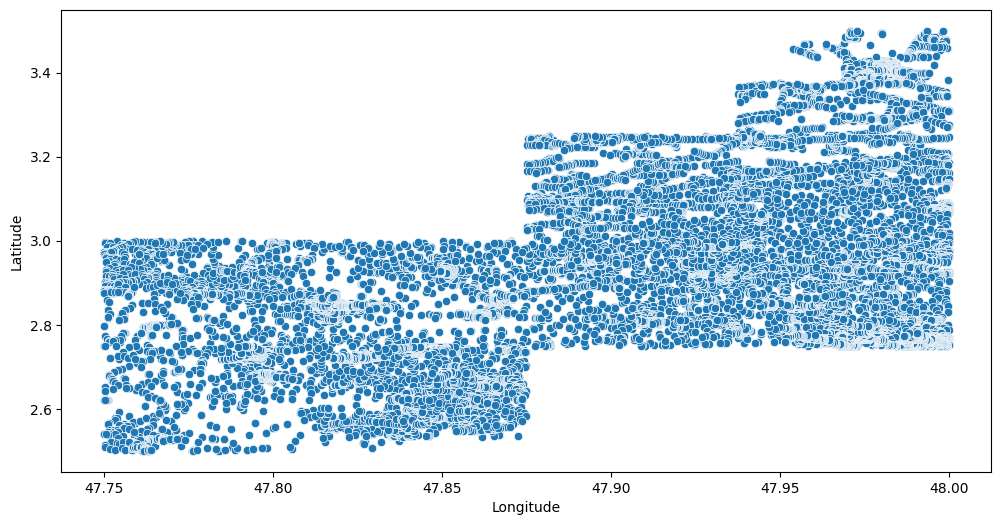

In [59]:
plot_scatter(combined_df)

In [90]:
X = combined_df['Longitude']
Y = combined_df['Latitude']

### Fusion of positions 

In [91]:
import numpy as np

num_cells = 50

min_longitude = np.min(X)
max_longitude = np.max(X)

min_latitude = np.min(Y)
max_latitude = np.max(Y)

delta_longitude = (max_longitude - min_longitude)/num_cells
delta_latitude =  (max_latitude - min_latitude)/num_cells

x_values = np.linspace(min_longitude, max_longitude, num_cells)
y_values = np.linspace(min_latitude, max_latitude, num_cells)

Longitude, Latitude = np.meshgrid(x_values, y_values, indexing='xy')

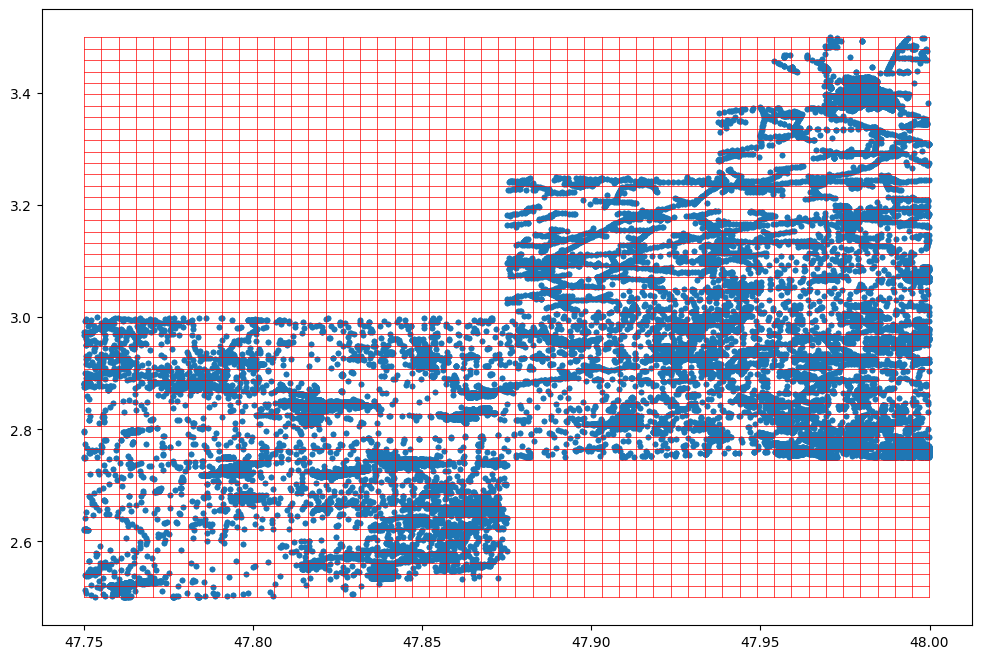

In [92]:
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, marker='.')
plt.plot(Longitude.T, Latitude.T, color='red', linestyle = '-', linewidth = 0.5)
plt.plot(Longitude, Latitude, color='red', linestyle = '-', linewidth = 0.5)
plt.show()

In [93]:
regions = {}

for position in combined_df.iterrows():
    longitude_ = position[1].Longitude
    latitude_ = position[1].Latitude
    # break

    i_, j_ = int(((longitude_ - min_longitude)// delta_longitude)), int(((latitude_ - min_latitude)// delta_latitude))
    if (i_, j_) in regions:
        regions[(i_, j_)].append(position)
    else:
        regions[(i_, j_)] = []

In [96]:
print(regions.keys())

dict_keys([(43, 48), (43, 47), (42, 48), (41, 48), (40, 47), (41, 47), (42, 46), (43, 46), (44, 47), (46, 47), (45, 48), (44, 49), (43, 49), (45, 49), (46, 49), (48, 48), (47, 48), (48, 49), (49, 49), (49, 48), (49, 47), (47, 47), (47, 46), (48, 46), (49, 46), (49, 45), (46, 45), (46, 46), (45, 46), (44, 46), (45, 45), (44, 45), (43, 45), (46, 44), (45, 44), (44, 44), (43, 44), (43, 43), (44, 43), (45, 43), (46, 43), (47, 43), (47, 44), (48, 43), (48, 44), (47, 45), (48, 45), (49, 44), (49, 43), (48, 42), (49, 42), (48, 41), (49, 40), (48, 40), (47, 41), (47, 40), (46, 41), (46, 42), (45, 41), (46, 40), (44, 41), (43, 41), (44, 42), (45, 42), (42, 43), (42, 42), (41, 42), (40, 42), (40, 43), (41, 43), (39, 43), (38, 43), (37, 43), (38, 42), (37, 42), (39, 42), (40, 41), (37, 41), (39, 41), (40, 40), (41, 40), (41, 41), (42, 41), (42, 40), (43, 40), (43, 39), (41, 39), (39, 40), (38, 39), (38, 40), (37, 39), (39, 39), (37, 38), (38, 37), (38, 38), (37, 37), (40, 37), (41, 37), (41, 38),

In [100]:
sizes_of_regions = [len(values) for key, values in regions.items()]
print("Size of the largest area : ", np.max(sizes_of_regions))
print("Size of the smallest area : ", np.min(sizes_of_regions))
print("Mean of sizes : ", np.mean(sizes_of_regions))
print("Standard deviation of sizes : ", np.std(sizes_of_regions))

Size of the largest area :  3575
Size of the smallest area :  2
Mean of sizes :  78.29461538461538
Standard deviation of sizes :  207.78881320726302


In [106]:
print(len(regions[(8,1)]))

2


### Vectorization of regions 